# XGBoost Forecasting with Nixtla's MLForecast

## Dataset: AV

This notebook demonstrates how to use the XGBoost forecasting model
with the implementation provided by Nixtla's MLForecast library:

## Important note:

This notebook uses the following conda environments:

+ Under linux: tfm_cc, described in the tfm_cc.yml file (see environments folder).
+ Under macOS: tfm_cc_nixtla, described in the tfm_cc_nixtla.yml file (see environments folder). 

## Execution Notes:

The run times that appear below correspond to the execution of the notebook in a Mac M2 machine, 16GB of RAM.

## Load basic libraries

**Warning:** Model specific libraries will be loaded below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import logging



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error



## Load dataset

In [2]:
file_path = "../../data/filtered_df.csv"
df = pd.read_csv(file_path, delimiter=';')
df.head()

,time,Active_Power,Wind_speed_tower,Preassure,Generator_Speed,F1_v(90).Mean,F1_v(80).Mean,F1_v(70).Mean,F1_v(60).Mean,F1_v(50).Mean,F1_v(40).Mean,F1_v(30).Mean
0,01/09/2022 0:00,2505.48220,9.057124,1012.38360,1121.2102,9.023969,3.97405,9.076108,3.82628,8.992466,3.39136,8.827003
1,01/09/2022 1:00,1762.24210,8.078237,1012.41210,1073.9020,8.110137,3.97405,8.151952,3.82628,8.076786,3.39136,8.005285
2,01/09/2022 2:00,1460.83560,7.712017,1012.29083,1021.2429,7.527431,3.97405,7.615797,3.82628,7.517593,3.39136,7.461551
3,01/09/2022 3:00,926.81006,6.672135,1012.15690,894.0004,6.566134,3.97405,6.637816,3.82628,6.571112,3.39136,6.550666
4,01/09/2022 4:00,671.34590,6.100095,1012.09424,821.4349,5.988185,3.97405,6.049537,3.82628,5.986922,3.39136,5.982606


### Set datetime format and index

In [3]:
df['time'] = pd.to_datetime(df['time'], format='%d/%m/%Y %H:%M')
df.set_index('time', inplace=True)
df.head()

,Active_Power,Wind_speed_tower,Preassure,Generator_Speed,F1_v(90).Mean,F1_v(80).Mean,F1_v(70).Mean,F1_v(60).Mean,F1_v(50).Mean,F1_v(40).Mean,F1_v(30).Mean
time,,,,,,,,,,,
2022-09-01 00:00:00,2505.48220,9.057124,1012.38360,1121.2102,9.023969,3.97405,9.076108,3.82628,8.992466,3.39136,8.827003
2022-09-01 01:00:00,1762.24210,8.078237,1012.41210,1073.9020,8.110137,3.97405,8.151952,3.82628,8.076786,3.39136,8.005285
2022-09-01 02:00:00,1460.83560,7.712017,1012.29083,1021.2429,7.527431,3.97405,7.615797,3.82628,7.517593,3.39136,7.461551
2022-09-01 03:00:00,926.81006,6.672135,1012.15690,894.0004,6.566134,3.97405,6.637816,3.82628,6.571112,3.39136,6.550666
2022-09-01 04:00:00,671.34590,6.100095,1012.09424,821.4349,5.988185,3.97405,6.049537,3.82628,5.986922,3.39136,5.982606


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7248 entries, 2022-09-01 00:00:00 to 2023-06-29 23:00:00
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Active_Power      7248 non-null   float64
 1   Wind_speed_tower  7248 non-null   float64
 2   Preassure         7248 non-null   float64
 3   Generator_Speed   7248 non-null   float64
 4   F1_v(90).Mean     7162 non-null   float64
 5   F1_v(80).Mean     7162 non-null   float64
 6   F1_v(70).Mean     7162 non-null   float64
 7   F1_v(60).Mean     7162 non-null   float64
 8   F1_v(50).Mean     7162 non-null   float64
 9   F1_v(40).Mean     7162 non-null   float64
 10  F1_v(30).Mean     7162 non-null   float64
dtypes: float64(11)
memory usage: 679.5 KB


In this example, we only use the following variables:

In [5]:
df = df.iloc[:, :4]

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7248 entries, 2022-09-01 00:00:00 to 2023-06-29 23:00:00
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Active_Power      7248 non-null   float64
 1   Wind_speed_tower  7248 non-null   float64
 2   Preassure         7248 non-null   float64
 3   Generator_Speed   7248 non-null   float64
dtypes: float64(4)
memory usage: 283.1 KB


### Check for missing values, time gaps, and duplicated dates

There are no missing data in this dataset

In [6]:
print(df.isna().sum())

Active_Power        0
Wind_speed_tower    0
Preassure           0
Generator_Speed     0
dtype: int64


In [7]:
duplicate_dates = df.index[df.index.duplicated(keep='first')]
print(f"Number of duplicate timestamps: {len(duplicate_dates)}")
print(duplicate_dates)

Number of duplicate timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)


In [8]:
expected_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing_dates = expected_range.difference(df.index)

print(f"Number of missing timestamps: {len(missing_dates)}")
print(missing_dates[:30])  # show first 10 missing ones

Number of missing timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='h')


### Target and exogenous variables

In [9]:
target = 'Active_Power'

features = [col for col in df.columns if col != target]
features = features[:1]
features


['Wind_speed_tower']

In [10]:
df = df[features + [target]]
df

,Wind_speed_tower,Active_Power
time,,
2022-09-01 00:00:00,9.057124,2505.48220
2022-09-01 01:00:00,8.078237,1762.24210
2022-09-01 02:00:00,7.712017,1460.83560
2022-09-01 03:00:00,6.672135,926.81006
2022-09-01 04:00:00,6.100095,671.34590
...,...,...
2023-06-29 19:00:00,6.510803,843.02400
2023-06-29 20:00:00,6.739559,954.61980
2023-06-29 21:00:00,5.570358,530.78204


## Train / Validation / Test split

We select the following lengths for the train, validation, and test sets:

In [11]:
train_len = 5800 # approx int(np.ceil(df.shape[0] * 0.8))
print(f"Train length: {train_len}")

val_len = (df.shape[0] - train_len) // 2
print(f"Validation length: {val_len}")

test_len = df.shape[0] - train_len - val_len
print(f"Test length: {test_len}")

Train length: 5800
Validation length: 724
Test length: 724


And we split the time series into train, validation, and test sets:

In [12]:
train_df = df.iloc[:train_len]
train_df

,Wind_speed_tower,Active_Power
time,,
2022-09-01 00:00:00,9.057124,2505.482200
2022-09-01 01:00:00,8.078237,1762.242100
2022-09-01 02:00:00,7.712017,1460.835600
2022-09-01 03:00:00,6.672135,926.810060
2022-09-01 04:00:00,6.100095,671.345900
...,...,...
2023-04-30 11:00:00,4.004780,150.152160
2023-04-30 12:00:00,3.007964,0.000000
2023-04-30 13:00:00,1.408475,8.929723


In [13]:
val_df = df.iloc[train_len:(train_len + val_len)]
val_df

,Wind_speed_tower,Active_Power
time,,
2023-04-30 16:00:00,3.812496,178.24010
2023-04-30 17:00:00,3.483967,0.00000
2023-04-30 18:00:00,4.239082,147.56505
2023-04-30 19:00:00,4.626727,274.05078
2023-04-30 20:00:00,5.066225,449.61557
...,...,...
2023-05-30 15:00:00,3.378462,0.00000
2023-05-30 16:00:00,3.660170,158.17046
2023-05-30 17:00:00,3.581221,148.18813


In [14]:
test_df = df.iloc[(train_len + val_len):]
test_df

,Wind_speed_tower,Active_Power
time,,
2023-05-30 20:00:00,3.526134,141.81660
2023-05-30 21:00:00,3.746263,170.12517
2023-05-30 22:00:00,2.346617,0.00000
2023-05-30 23:00:00,2.987464,0.00000
2023-05-31 00:00:00,3.670265,159.70273
...,...,...
2023-06-29 19:00:00,6.510803,843.02400
2023-06-29 20:00:00,6.739559,954.61980
2023-06-29 21:00:00,5.570358,530.78204


## Time series split visualization

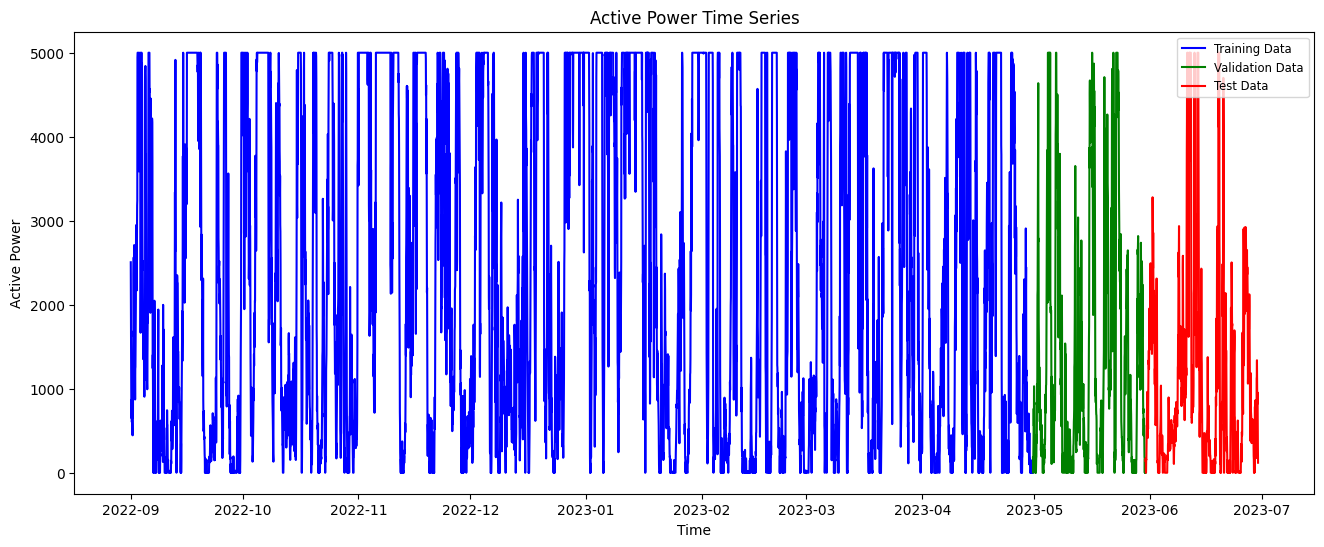

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(train_df["Active_Power"], label="Training Data", color='blue')
plt.plot(val_df["Active_Power"], label="Validation Data", color='green')
plt.plot(test_df["Active_Power"], label="Test Data", color='red')
plt.title("Active Power Time Series")
plt.xlabel("Time")
plt.ylabel("Active Power")
plt.legend(fontsize='small')

We will also create copies of the train, validation, and test sets to use them later in the notebook.

In [16]:
train_df_original = train_df.copy()
val_df_original = val_df.copy()
test_df_original = test_df.copy()

## Data scaling

We apply the min-max scaler fitted to the training set to the train, validation, and test sets (to avoid data leakage). 

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.set_output(transform='pandas')

scaler.fit(train_df)
train_df = scaler.transform(train_df)

val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

Let us check the result

In [18]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wind_speed_tower,5800.0,0.370283,0.181766,0.0,0.230103,0.341549,0.499679,1.0
Active_Power,5800.0,0.502231,0.396148,0.0,0.112238,0.416912,1.000000,1.0


## Nixtla Dataset Format

Convert to NeuralForecast format (ds, y, unique_id)

In [19]:
train_df_nf = train_df.copy()

train_df_nf = train_df_nf.rename(columns={target: 'y'})

train_df_nf['ds'] = train_df_nf.index

train_df_nf['unique_id'] = 'series_1'


Move ds and unique_id to front

In [20]:
train_df_nf = train_df_nf[['unique_id', 'ds', 'y'] + features]
train_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2022-09-01 00:00:00,series_1,2022-09-01 00:00:00,0.501096,0.372027
2022-09-01 01:00:00,series_1,2022-09-01 01:00:00,0.352448,0.331578
2022-09-01 02:00:00,series_1,2022-09-01 02:00:00,0.292167,0.316446
2022-09-01 03:00:00,series_1,2022-09-01 03:00:00,0.185362,0.273476
2022-09-01 04:00:00,series_1,2022-09-01 04:00:00,0.134269,0.249839
...,...,...,...,...
2023-04-30 11:00:00,series_1,2023-04-30 11:00:00,0.030030,0.163258
2023-04-30 12:00:00,series_1,2023-04-30 12:00:00,0.000000,0.122068
2023-04-30 13:00:00,series_1,2023-04-30 13:00:00,0.001786,0.055975


Same for validation and test sets

In [21]:
val_df_nf = val_df.copy()
val_df_nf = val_df_nf.rename(columns={target: 'y'})
val_df_nf['ds'] = val_df_nf.index

val_df_nf['unique_id'] = 'series_1'

val_df_nf = val_df_nf[['unique_id', 'ds', 'y'] + features]
val_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2023-04-30 16:00:00,series_1,2023-04-30 16:00:00,0.035648,0.155312
2023-04-30 17:00:00,series_1,2023-04-30 17:00:00,0.000000,0.141737
2023-04-30 18:00:00,series_1,2023-04-30 18:00:00,0.029513,0.172939
2023-04-30 19:00:00,series_1,2023-04-30 19:00:00,0.054810,0.188957
2023-04-30 20:00:00,series_1,2023-04-30 20:00:00,0.089923,0.207118
...,...,...,...,...
2023-05-30 15:00:00,series_1,2023-05-30 15:00:00,0.000000,0.137377
2023-05-30 16:00:00,series_1,2023-05-30 16:00:00,0.031634,0.149018
2023-05-30 17:00:00,series_1,2023-05-30 17:00:00,0.029638,0.145756


In [22]:
test_df_nf = test_df.copy()
test_df_nf = test_df_nf.rename(columns={target: 'y'})
test_df_nf['ds'] = test_df_nf.index

test_df_nf['unique_id'] = 'series_1'

test_df_nf = test_df_nf[['unique_id', 'ds', 'y'] + features]
test_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2023-05-30 20:00:00,series_1,2023-05-30 20:00:00,0.028363,0.143479
2023-05-30 21:00:00,series_1,2023-05-30 21:00:00,0.034025,0.152575
2023-05-30 22:00:00,series_1,2023-05-30 22:00:00,0.000000,0.094740
2023-05-30 23:00:00,series_1,2023-05-30 23:00:00,0.000000,0.121221
2023-05-31 00:00:00,series_1,2023-05-31 00:00:00,0.031941,0.149435
...,...,...,...,...
2023-06-29 19:00:00,series_1,2023-06-29 19:00:00,0.168605,0.266810
2023-06-29 20:00:00,series_1,2023-06-29 20:00:00,0.190924,0.276262
2023-06-29 21:00:00,series_1,2023-06-29 21:00:00,0.106156,0.227949


Create a **joint dataset** with train and validation to fit into Nixtla's framework.

In [23]:
train_val_df = pd.concat([train_df_nf, val_df_nf], axis=0)
train_val_df.reset_index(drop=True, inplace=True)
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6524 entries, 0 to 6523
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         6524 non-null   object        
 1   ds                6524 non-null   datetime64[ns]
 2   y                 6524 non-null   float64       
 3   Wind_speed_tower  6524 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 204.0+ KB


And similarly a **full dataset** with train, validation and test sets.

In [24]:
full_df_nf = pd.concat([train_df_nf, val_df_nf, test_df_nf], axis=0)
full_df_nf.reset_index(drop=True, inplace=True)
full_df_nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         7248 non-null   object        
 1   ds                7248 non-null   datetime64[ns]
 2   y                 7248 non-null   float64       
 3   Wind_speed_tower  7248 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 226.6+ KB


## Set the forecast horizon and input length

In [25]:
horizon = 3
input_size = 6

# XGBoost

Let us load the required libraries for the XGBoost model.

In [26]:
from mlforecast import MLForecast
from mlforecast.auto import AutoModel, AutoXGBoost, AutoMLForecast

import optuna

import xgboost as xgb



We create a dictionary to store the predictions of the XGBoost models for each prediction horizon.

In [27]:
preds_df = {}

And another one to store the fitted models and their parameters

In [28]:
xgb_dict = {}

Next we create a function that will define the hyperparameter grid for the Optuna optimization process of the XGBoost models.

In [29]:
def xgb_forecasting_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'random_state': 42,
        'tree_method': 'hist',  # more efficient for large datasets
        'verbosity': 0
    }

In [30]:
%%capture --no-stderr --no-display

start_time = time.time()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.getLogger("lightning_fabric.utilities.seed").setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.ERROR)

# The following loop processes each horizon from 1 to the maximum specified horizon value.
for h in range(1, horizon + 1):
# for h in range(1, 2):

    # Initialize the dictionary to store models and parameters for each horizon
    xgb_dict[f'{h}h'] = {}

    print(f"Processing horizon: {h}h")

    # Create a copy of the full DataFrame for the current horizon
    full_df_nf_h = full_df_nf.copy()

    # Create the target variable by shifting the 'y' column by 'h' hours into the future (negative lags)
    full_df_nf_h['h_target'] = full_df_nf_h['y'].shift(-h)
    
    # Also create lagged features for the 'Wind_speed_tower' column
    # making sure that each model only has access to past values of wind
    for k in range(1, horizon + 1):
        full_df_nf_h[f'Wind_speed_tower_lag{k}'] = full_df_nf_h['Wind_speed_tower'].shift(k)

    # Remove the non-lagged columns and rename the target column
    full_df_nf_h.drop(columns=['y', 'Wind_speed_tower'], inplace=True)
    full_df_nf_h.rename(columns={'h_target': 'y'}, inplace=True)
    
    # Select the data corresponding to the train and validation sets
    train_val_df_h = full_df_nf_h.head(train_val_df.shape[0]).copy()

    # Use init_config to pass the lags of the target variable to the auto model
    def my_init_config(trial: optuna.Trial):
        return {
            'lags': range(1 + h, input_size + 1 + h)
        }
        
    # Use fit_config to indicate that all the features (Wind) are dynamic features
    def my_fit_config(trial: optuna.Trial):    
        return {
            'static_features': []
        }

    # Now define an auto model for XGBoost with the specified configurations
    auto_xgb = AutoMLForecast(
        models={'xgb': AutoXGBoost()},
        freq='H',
        init_config=my_init_config,
        fit_config=my_fit_config,
        num_threads=1)
    
    # Fit the model on the training and validation data (Optuna optimized)
    auto_xgb.fit(train_val_df_h,
                 h = 1,
                 num_samples= 20,
                 n_windows=10)


    # Get optimal parameters, and store the model
    xgb_dict[f'{h}h']['model'] = auto_xgb.models['xgb'].model
    xgb_dict[f'{h}h']['best_params'] = auto_xgb.results_['xgb'].best_params

    # Now use that optimized model (as a regular model) to make predictions
    # These are **one-step-ahead predictions of the future-lagged output**
    fcst = MLForecast(
        models=[xgb_dict[f'{h}h']['model']],
        freq='H',
        lags=range(1 + h, input_size + 1 + h),  
        num_threads=1)
        
    # The value of n moves across the test set, predicting one step at a time
    # We use the first row (n = 0) of the test set to initialize the output DataFrame
    n = 0 

    # This is the data used for the 0-th prediction
    train_val_df_h_n = full_df_nf_h.head(train_val_df.shape[0] + n).copy()

    # Fit the optimal model to that data
    fcst.fit(train_val_df_h_n, static_features=[])

    # Also define the X_df DataFrame, which contains the features for the 0-th prediction
    X_df=full_df_nf_h.head(train_val_df_h_n.shape[0] + 1).drop(columns=['y'])

    # Predict and use the predictions to initialize the output DataFrame
    preds_df[f'{h}h'] = fcst.predict(h = 1, X_df=X_df)
    
    # This loop iterates over the remaining rows of the test set, predicting one step at a time
    # using the same steps
    for n in range(1, test_df_nf.shape[0] - h + 1):
        # Data for n-th row
        train_val_df_h_n = full_df_nf_h.head(train_val_df.shape[0] + n).copy()
        # Fit the model to the data for n-th row
        fcst.fit(train_val_df_h_n, static_features=[])
        # Define the X_df DataFrame for the n-th prediction
        X_df = full_df_nf_h.head(train_val_df_h_n.shape[0] + n).drop(columns=['y'])
        # Predict the next step using the fitted model and the X_df DataFrame
        # and concatenate the predictions to the output DataFrame
        preds_df[f'{h}h'] = pd.concat([preds_df[f'{h}h'], fcst.predict(h = 1, X_df=X_df)], axis=0)
 

    # When the predictions are done, we rename the columns and set the index
    preds_df[f'{h}h'].rename(columns={'XGBRegressor': f'pred_{h}h'}, inplace=True)
    preds_df[f'{h}h'].set_index('ds', inplace=True)

end_time = time.time()
elapsed_time = end_time - start_time


In [31]:
print(f"Elapsed time: {elapsed_time / 60:.2f} minutes")

Elapsed time: 5.63 minutes


Let us take a look at the hyperparameter selected by Optuna for the XGBoost models for each prediction horizon.

In [32]:
xgb_dict['1h']['best_params']

{'n_estimators': 212,
 'max_depth': 4,
 'learning_rate': 0.07746937426787545,
 'subsample': 0.18739114821375516,
 'colsample_bytree': 0.8541504167489236,
 'reg_lambda': 5.8720164445859745e-08,
 'reg_alpha': 0.6481502906344189,
 'min_child_weight': 6}

In [33]:
xgb_dict['2h']['best_params']

{'n_estimators': 372,
 'max_depth': 5,
 'learning_rate': 0.040296776607459256,
 'subsample': 0.15420292446634284,
 'colsample_bytree': 0.700090043901101,
 'reg_lambda': 0.002317944093186113,
 'reg_alpha': 4.820149280505929e-07,
 'min_child_weight': 3}

In [34]:
xgb_dict['3h']['best_params']

{'n_estimators': 538,
 'max_depth': 10,
 'learning_rate': 0.07867168321867006,
 'subsample': 0.43072349571729895,
 'colsample_bytree': 0.8925838180973231,
 'reg_lambda': 0.85811724289601,
 'reg_alpha': 0.0002663765147239373,
 'min_child_weight': 7}

# Model Performance Evaluation

Let us also look at the prediction dataframes for the XGBoost models for each prediction horizon.

In [35]:
preds_df['1h']

,unique_id,pred_1h
ds,,
2023-05-30 20:00:00,series_1,0.008937
2023-05-30 21:00:00,series_1,0.035574
2023-05-30 22:00:00,series_1,0.036920
2023-05-30 23:00:00,series_1,0.003352
2023-05-31 00:00:00,series_1,0.030865
...,...,...
2023-06-29 19:00:00,series_1,0.161883
2023-06-29 20:00:00,series_1,0.158666
2023-06-29 21:00:00,series_1,0.230728


In [36]:
preds_df['2h']

,unique_id,pred_2h
ds,,
2023-05-30 20:00:00,series_1,0.038495
2023-05-30 21:00:00,series_1,0.043948
2023-05-30 22:00:00,series_1,0.044825
2023-05-30 23:00:00,series_1,0.028888
2023-05-31 00:00:00,series_1,0.038939
...,...,...
2023-06-29 18:00:00,series_1,0.280335
2023-06-29 19:00:00,series_1,0.163448
2023-06-29 20:00:00,series_1,0.241934


In [37]:
preds_df['3h']

,unique_id,pred_3h
ds,,
2023-05-30 20:00:00,series_1,0.038756
2023-05-30 21:00:00,series_1,0.061229
2023-05-30 22:00:00,series_1,0.070329
2023-05-30 23:00:00,series_1,0.041699
2023-05-31 00:00:00,series_1,0.037802
...,...,...
2023-06-29 17:00:00,series_1,0.459095
2023-06-29 18:00:00,series_1,0.500217
2023-06-29 19:00:00,series_1,0.254109


And let us plot the predictions of the XGBoost models for each prediction horizon.

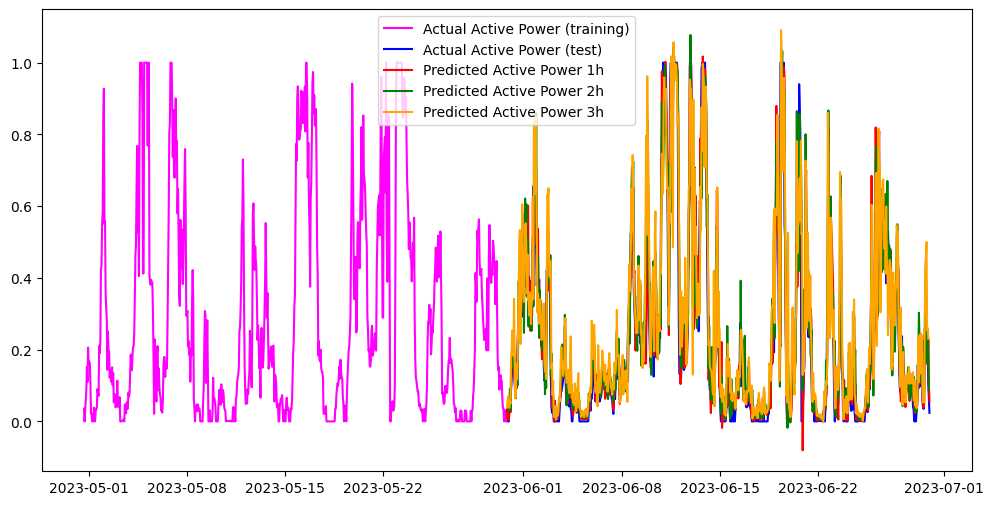

In [38]:
%matplotlib inline

plt.figure(figsize=(12, 6))
plt.plot(val_df_nf["y"], label="Actual Active Power (training)", color='magenta')
plt.plot(test_df_nf["y"], label="Actual Active Power (test)", color='blue')
for h in range(1, horizon + 1):
    colors = ['red', 'green', 'orange', 'purple', 'brown', 'cyan']
    plt.plot(
        preds_df[f'{h}h'][f'pred_{h}h'],
        label=f"Predicted Active Power {h}h",
        color=colors[(h - 1) % len(colors)]
    )
plt.legend()
plt.show();plt.close()


### MAE computation

We will next compute the MAE for each of the predictions in the dictionary. 

In [39]:
from sklearn.metrics import mean_absolute_error

#### Mae for 1h preddictions

In [40]:
mae1h_df = preds_df['1h'].copy()[['pred_1h']]
mae1h_df


,pred_1h
ds,
2023-05-30 20:00:00,0.008937
2023-05-30 21:00:00,0.035574
2023-05-30 22:00:00,0.036920
2023-05-30 23:00:00,0.003352
2023-05-31 00:00:00,0.030865
...,...
2023-06-29 19:00:00,0.161883
2023-06-29 20:00:00,0.158666
2023-06-29 21:00:00,0.230728


We need to add the exogenous variables as they were used by the scaler. 

In [41]:
mae1h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values)
mae1h_df

,Wind_speed_tower,pred_1h
ds,,
2023-05-30 20:00:00,0.143479,0.008937
2023-05-30 21:00:00,0.152575,0.035574
2023-05-30 22:00:00,0.094740,0.036920
2023-05-30 23:00:00,0.121221,0.003352
2023-05-31 00:00:00,0.149435,0.030865
...,...,...
2023-06-29 19:00:00,0.266810,0.161883
2023-06-29 20:00:00,0.276262,0.158666
2023-06-29 21:00:00,0.227949,0.230728


In [42]:
# mae1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mae1h_df)[:,1], test_df_original["Active_Power"])

320.9034988082673

#### Mae for 2h preddictions

In [43]:
mae2h_df = preds_df['2h'].copy()[['pred_2h']]
mae2h_df


,pred_2h
ds,
2023-05-30 20:00:00,0.038495
2023-05-30 21:00:00,0.043948
2023-05-30 22:00:00,0.044825
2023-05-30 23:00:00,0.028888
2023-05-31 00:00:00,0.038939
...,...
2023-06-29 18:00:00,0.280335
2023-06-29 19:00:00,0.163448
2023-06-29 20:00:00,0.241934


In [44]:
mae2h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values[:-1])
mae2h_df

,Wind_speed_tower,pred_2h
ds,,
2023-05-30 20:00:00,0.143479,0.038495
2023-05-30 21:00:00,0.152575,0.043948
2023-05-30 22:00:00,0.094740,0.044825
2023-05-30 23:00:00,0.121221,0.028888
2023-05-31 00:00:00,0.149435,0.038939
...,...,...
2023-06-29 18:00:00,0.262979,0.280335
2023-06-29 19:00:00,0.266810,0.163448
2023-06-29 20:00:00,0.276262,0.241934


In [45]:
# mae1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mae2h_df)[:,1], test_df_original["Active_Power"][:-1])

384.08429080482756

#### Mae for 3h preddictions

In [46]:
mae3h_df = preds_df['3h'].copy()[['pred_3h']]
mae3h_df


,pred_3h
ds,
2023-05-30 20:00:00,0.038756
2023-05-30 21:00:00,0.061229
2023-05-30 22:00:00,0.070329
2023-05-30 23:00:00,0.041699
2023-05-31 00:00:00,0.037802
...,...
2023-06-29 17:00:00,0.459095
2023-06-29 18:00:00,0.500217
2023-06-29 19:00:00,0.254109


In [47]:
mae3h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values[:-2])
mae3h_df

,Wind_speed_tower,pred_3h
ds,,
2023-05-30 20:00:00,0.143479,0.038756
2023-05-30 21:00:00,0.152575,0.061229
2023-05-30 22:00:00,0.094740,0.070329
2023-05-30 23:00:00,0.121221,0.041699
2023-05-31 00:00:00,0.149435,0.037802
...,...,...
2023-06-29 17:00:00,0.284871,0.459095
2023-06-29 18:00:00,0.262979,0.500217
2023-06-29 19:00:00,0.266810,0.254109


In [48]:
mean_absolute_error(scaler.inverse_transform(mae3h_df)[:,1], test_df_original["Active_Power"][:-2])

442.7465388013822